# Short Utterance Adapt

In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from batch_sv_system_utils import get_embeds, cosine_sim, compute_error
from batch_sv_system_utils import compute_eer
from utils import key2df, df2dict

In [4]:
def get_id2idx(keys):
    key_df = key2df(keys)
    id2idx, idx2id = df2dict(key_df) 
    
    return id2idx

In [52]:
# plda_embed_dir = "embeddings/voxc2_fbank64_voxc2untied_xvector/"
embed_dir = "embeddings/voxc2_fbank64_voxc2untied_100f_xvector/"
sv_embeds = np.load(embed_dir + "/sv_embeds.npy")
plda_model_dir = embed_dir + "plda_train/"
keys = pickle.load(open(embed_dir + "/sv_keys.pkl", "rb"))
id2idx = get_id2idx(keys)

## Run Trial - Score fusion

In [53]:
trial = pickle.load(open("trials/enr306/enr306_closedset_big/FS_9/trials.pkl", "rb"))
# trial = pickle.load(open("trials/enr306/short_enr1/trials.pkl", "rb"))

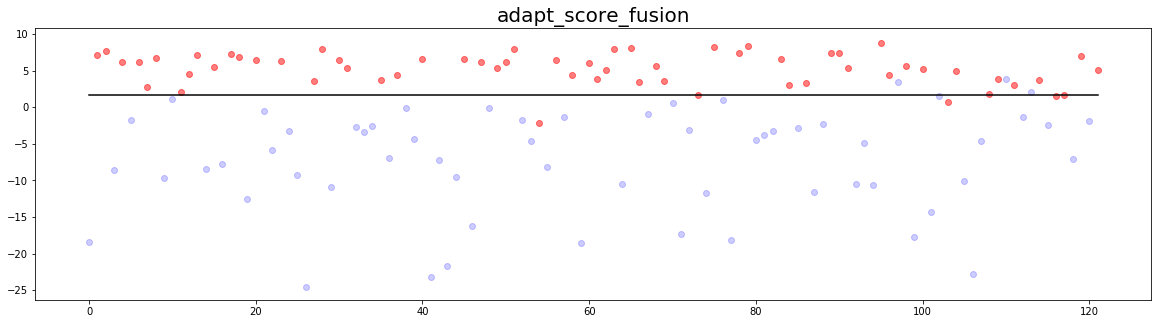

[pos_adapt] n_adapted:38, adapt_acc:1.000
[eer] eer=0.1177, fpr=0.1188, fnr=0.1167, thres=0.6025
n_enr:2
[eer] eer=0.0762, fpr=0.0773, fnr=0.0750, thres=1.1041
n_enr:5
[eer] eer=0.0845, fpr=0.0856, fnr=0.0833, thres=1.3420
n_enr:8
[eer] eer=0.0713, fpr=0.0718, fnr=0.0708, thres=1.6553
n_enr:11
[eer] eer=0.0713, fpr=0.0718, fnr=0.0708, thres=1.4370
n_enr:14
[eer] eer=0.0665, fpr=0.0663, fnr=0.0667, thres=1.6870
n_enr:17
[eer] eer=0.0699, fpr=0.0691, fnr=0.0708, thres=1.6949
n_enr:20
[eer] eer=0.0699, fpr=0.0691, fnr=0.0708, thres=1.6020
n_enr:23
[eer] eer=0.0796, fpr=0.0801, fnr=0.0792, thres=1.6340
n_enr:26
[eer] eer=0.0727, fpr=0.0746, fnr=0.0708, thres=1.7083
n_enr:29
[eer] eer=0.0727, fpr=0.0746, fnr=0.0708, thres=1.6626
n_enr:32
[eer] eer=0.0810, fpr=0.0829, fnr=0.0792, thres=1.5101
n_enr:35
[eer] eer=0.0810, fpr=0.0829, fnr=0.0792, thres=1.6239
n_enr:38
[eer] eer=0.0796, fpr=0.0801, fnr=0.0792, thres=1.6416


In [65]:
 from batch_sv_system_utils import run_trial, plot_score 

t_idx = 7
enr_spk, enr_ids, test_trial, adapt_trial, ood_trial= trial[t_idx]
test_trial = list(test_trial)
test_trial[0] = test_trial[0] + ood_trial[0]
test_trial[1] = test_trial[1] + ood_trial[1]

# enr_spk, enr_ids, adapt_trial, test_trial= trial[t_idx]

eT = 5

init_enr_embeds = get_embeds(enr_ids, sv_embeds, id2idx, norm=False)[:1]
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, id2idx, norm=False)
test_embeds = get_embeds(test_trial[0], sv_embeds, id2idx, norm=False)

### adapt trial
adapt_scores = run_trial(enr_embeds, adapt_embeds, adapt_trial[1],
                         plda_dir=plda_model_dir, 
                         plot=True, title="adapt_score_fusion")
adapt_score_fusion = adapt_scores.mean(0)
adapt_enr_idx = np.nonzero(adapt_score_fusion > eT)
adapt_enr_acc = np.array(adapt_trial[1])[adapt_enr_idx].mean()
adapt_enr_embeds = adapt_embeds[adapt_enr_idx]
print("[pos_adapt] n_adapted:{}, adapt_acc:{:.3f}".format(len(adapt_enr_idx[0]), adapt_enr_acc))

### score fusion
total_enr_embeds = np.concatenate([init_enr_embeds, adapt_enr_embeds], axis=0)

### test trial
init_score = run_trial(init_enr_embeds, test_embeds, test_trial[1],
                       plda_dir=plda_model_dir, neg_embeds=None,
                       plot=False, title="score_fusion(plda, initial)",
                       verbose=True)

for n_enr in range(2, len(total_enr_embeds), 3):
    print("n_enr:{}".format(n_enr))
    total_score= run_trial(total_enr_embeds[:n_enr], test_embeds, test_trial[1],
                           plda_dir=plda_model_dir, neg_embeds=None,
                           plot=False, title="score_fusion(plda, adapt_3)",
                           verbose=True)

In [50]:
total_score[:3]

array([[-26.01368 ,   7.413336,   8.96114 , ..., -10.50224 ,  -2.567244,
        -18.85234 ],
       [-32.58043 ,  14.05748 ,  15.65969 , ..., -11.81906 ,  -9.3563  ,
        -24.95876 ],
       [-23.82671 ,  14.49788 ,  16.44465 , ...,  -8.354749,  -1.70026 ,
        -25.49563 ]])

In [51]:
total_score[3:4]

array([[-36.25076  ,  16.74293  ,  17.18775  , -13.25439  ,   6.589597 ,
          7.403083 , -10.90085  ,   8.210735 ,  14.05147  ,  15.36514  ,
        -13.21071  ,  14.51952  , -53.94011  ,  17.21947  , -39.03301  ,
        -19.95747  ,  17.68912  ,  -5.63044  , -34.03112  ,   1.187588 ,
        -49.37119  , -57.41652  ,  14.02333  ,  14.45948  , -41.34952  ,
        -16.98206  , -36.86841  ,  -3.756251 , -38.05252  ,   4.872194 ,
        -59.9915   , -11.5383   ,   4.959165 ,   9.636471 , -57.73317  ,
         18.53433  ,  -5.591255 ,  19.56472  ,   3.561266 , -46.17281  ,
        -59.21566  , -10.80055  ,  15.0154   ,  14.44715  ,  17.88146  ,
         14.19305  ,   9.849813 , -39.77138  ,  13.21959  ,   6.920402 ,
         10.35065  , -21.96473  , -20.23186  ,  12.17629  , -32.7986   ,
         -2.106612 ,   6.096123 ,  14.12928  , -41.91906  ,  17.54666  ,
         21.05622  , -37.53418  ,   2.933962 ,  12.61961  ,  14.1223   ,
          7.611259 ,   6.571369 ,  11.84182  , -28.

In [46]:
# t_idx = 7
# enr_spk, enr_ids, test_trial, adapt_trial, ood_trial= trial[t_idx]
# test_trial = list(test_trial)
# test_trial[0] = test_trial[0] + ood_trial[0]
# test_trial[1] = test_trial[1] + ood_trial[1]

### get embeds
enr_embeds = get_embeds(enr_ids, sv_embeds, id2idx, norm=True)
test_embeds = get_embeds(test_trial[0], sv_embeds, id2idx, norm=True)

score_fusions = []
neg_score_fusions = []
enroll_embeds = []
neg_enroll_embeds = []
enroll_embeds = [enr for enr in enr_embeds]
for t, in_embed in enumerate(test_embeds):
    scores = cosine_sim(np.array(enroll_embeds), in_embed)
    score_fusion = scores.mean(0)
    if score_fusion > 0.7:
        enroll_embeds.append(in_embed)
    elif score_fusion < 0.4:
        neg_enroll_embeds.append(in_embed)
        
    score_fusions.append(score_fusion)
    
    if len(neg_enroll_embeds) > 0:
        neg_scores = cosine_sim(np.array(neg_enroll_embeds), in_embed)
        neg_scores = np.sort(neg_scores)[-3:]
        neg_score_fusion = neg_scores.mean(0)
        neg_score_fusion = score_fusion - neg_score_fusion
        neg_score_fusions.append(neg_score_fusion)
    else:
        neg_score_fusions.append(score_fusion)

base_eer = compute_eer(score_fusions, test_trial[1])
margin_eer = compute_eer(neg_score_fusions, test_trial[1])
print("base_eer:{:.4f}, margin_eer:{:.4f}".format(base_eer[0], margin_eer[0]))

base_eer:0.2285, margin_eer:0.2285


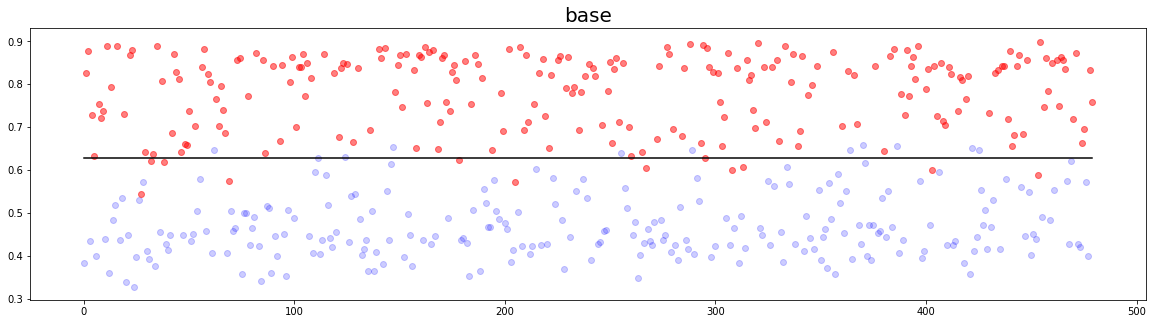

In [43]:
plot_score(np.array(score_fusions), test_trial[1], base_eer[-1], "base")

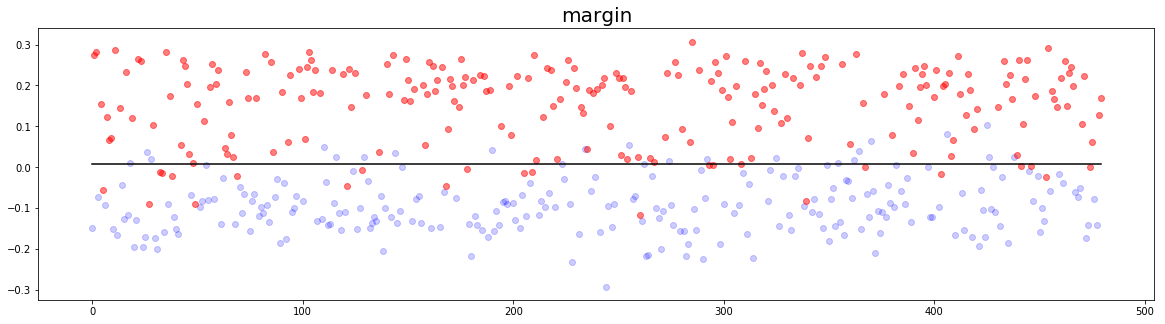

In [44]:
plot_score(np.array(neg_score_fusions), test_trial[1], margin_eer[-1], "margin")

## Iterate trials

In [491]:
test_scores = []
neg_test_scores = []
labels = []
for i, tr in enumerate(trial):
    ### for short
    enr_spk, enr_ids, adapt_trial, test_trial= trial[t_idx]

    ### for closed_set
    # enr_spk, enr_ids, test_trial, adapt_trial, ood_trial= trial[t_idx]
    # test_trial = list(test_trial)
    # test_trial[0] = test_trial[0] + ood_trial[0]
    # test_trial[1] = test_trial[1] + ood_trial[1]
    
    ### get embeds
    enr_embeds = get_embeds(enr_ids, sv_embeds, id2idx, norm=(not plda_model_dir))
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, id2idx, norm=(not plda_model_dir))
    test_embeds = get_embeds(test_trial[0], sv_embeds, id2idx, norm=(not plda_model_dir))

    ### adapt trial
    adapt_score_fusion = run_trial(enr_embeds, adapt_embeds, adapt_trial[1],
                             plda_dir=plda_model_dir, 
                             plot=False, title="adapt_score_fusion")
    adapt_enr_idx = np.nonzero(adapt_score_fusion > eT)
    adapt_enr_embeds = adapt_embeds[adapt_enr_idx]
#     adapt_enr_acc = np.array(adapt_trial[1])[adapt_enr_idx].mean()
#     print("[pos_adapt] n_adapted:{}, adapt_acc:{:.3f}".format(len(adapt_enr_idx[0]), adapt_enr_acc))

    neg_enr_idx = np.nonzero(adapt_score_fusion < neT)
    neg_enr_embeds = adapt_embeds[neg_enr_idx]
#     neg_enr_acc = (1 - np.array(adapt_trial[1]))[neg_enr_idx].mean()
#     print("[neg_adapt] n_adapted:{}, adapt_acc:{:.3f}".format(len(neg_enr_idx[0]), neg_enr_acc))

    ### score fusion
    total_enr_embeds = np.concatenate([enr_embeds, adapt_enr_embeds], axis=0)

    ### test trial
    total_test_score_fusion = run_trial(total_enr_embeds, test_embeds, test_trial[1], 
                                      plda_dir=plda_model_dir, neg_embeds=None)

    total_test_neg_score_fusion = run_trial(total_enr_embeds, test_embeds, test_trial[1],
                                  plda_dir=plda_model_dir, neg_embeds=neg_enr_embeds)
    
    test_scores += total_test_score_fusion.tolist()
    neg_test_scores += total_test_neg_score_fusion.tolist()
    labels += test_trial[1].tolist()

In [492]:
compute_eer(test_scores, labels)

(0.0544904137235116,
 0.05433333333333333,
 0.0544904137235116,
 0.6185755133628845)

In [20]:
val_set = pd.read_pickle("trials/enr306/validation_set.pkl")
# cohort_embeds = get_embeds(val_set.sample(n=5000).index, sv_embeds, id2idx)
# cohort_embeds = neg_enr_embeds

### init
enr_cohort_scores = cosine_sim(enr_embeds, cohort_embeds)
test_cohort_scores = cosine_sim(test_embeds, cohort_embeds)

enr_mean = enr_cohort_scores.mean(1).reshape(-1, 1)
enr_std = enr_cohort_scores.std(1).reshape(-1, 1)
test_mean = test_cohort_scores.mean(1).reshape(1, -1)
test_std = test_cohort_scores.std(1).reshape(1, -1)

norm_scores = ((init_test_scores - enr_mean)/enr_std + (init_test_scores - test_mean)/test_std)/2
eer, fpr, fnr, thres = compute_eer(norm_scores.mean(0), test_trial[1])
print("[init] eer={:.4f}, fpr={:.4f}, fnr={:.4f}, threshold={:.4f}".format(eer, fpr, fnr, thres))

############################################################################

### total
enr_cohort_scores = cosine_sim(total_enr_embeds, cohort_embeds)
test_cohort_scores = cosine_sim(test_embeds, cohort_embeds)

enr_mean = enr_cohort_scores.mean(1).reshape(-1, 1)
enr_std = enr_cohort_scores.std(1).reshape(-1, 1)
test_mean = test_cohort_scores.mean(1).reshape(1, -1)
test_std = test_cohort_scores.std(1).reshape(1, -1)

norm_scores = ((total_test_scores - enr_mean)/enr_std + (total_test_scores - test_mean)/test_std)/2
eer, fpr, fnr, thres = compute_eer(norm_scores.mean(0), test_trial[1])
print("[total] eer={:.4f}, fpr={:.4f}, fnr={:.4f}, threshold={:.4f}".format(eer, fpr, fnr, thres))

NameError: name 'init_test_scores' is not defined

## Searching the best enrollmnet

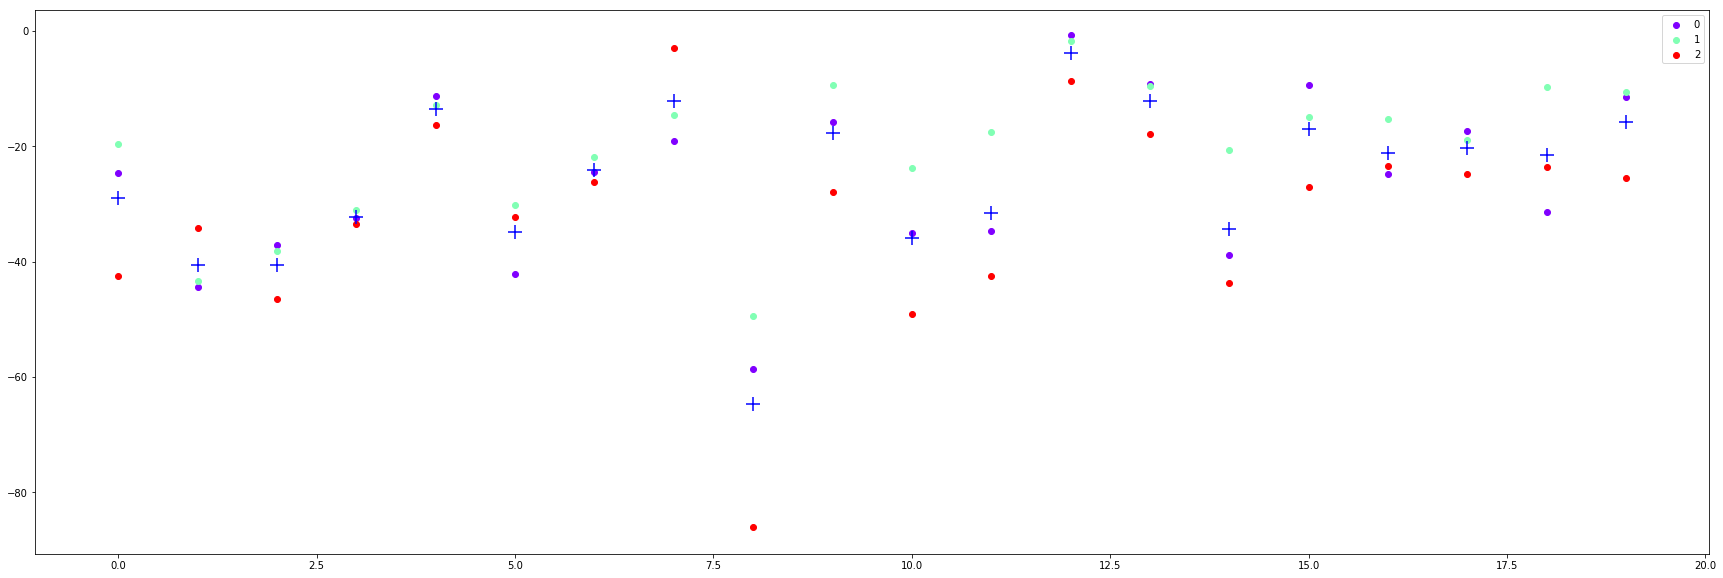

In [109]:
test_labels = np.array(test_trial[1])
scores_subset = total_test_scores[0:5, -20:]
labels_subset = test_labels[-20:]
plt.figure(figsize=(30, 10))
x = np.arange(scores_subset.shape[1])
ys = scores_subset
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
s_set = []
for y, c in zip(ys, colors):
    s = plt.scatter(x, y, color=c)
    s_set.append(s)
plt.legend(s_set, range(len(s_set)))
y_mean = scores_subset.mean(0)
plt.scatter(x[labels_subset==1], y_mean[labels_subset==1], marker='+', s=200, color='r')
plt.scatter(x[labels_subset==0], y_mean[labels_subset==0], marker='+', s=200, color='b')

In [493]:
compute_eer(neg_test_scores, labels)

(0.047, 0.047, 0.0464177598385469, 0.003913938999176025)

In [65]:
len(test_scores)

19562634

In [66]:
133/186

0.7150537634408602